In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, classification_report, 
                           confusion_matrix, roc_curve, auc)
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
import joblib
import warnings
warnings.filterwarnings("ignore")

## __Data and Preprocessing__

Dataset size: 48842 rows, 15 columns


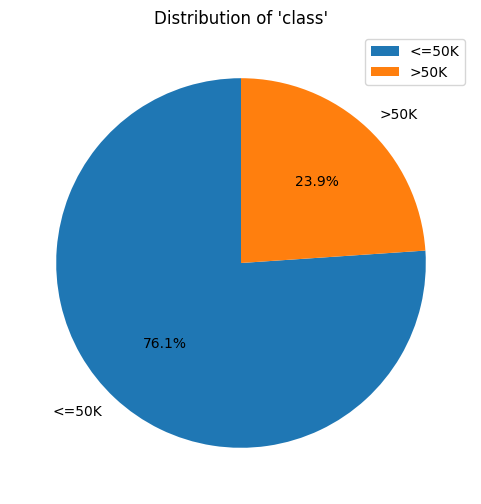

In [2]:
adult = fetch_openml("adult", version=1, as_frame=True)
df = adult.frame

print(f"Dataset size: {df.shape[0]} rows, {df.shape[1]} columns")

target_column = "class"
df[target_column].value_counts().plot.pie(
    autopct="%1.1f%%",
    startangle=90,
    figsize=(6, 6),
    legend=True,
    ylabel="",
)

plt.title(f"Distribution of '{target_column}'")
plt.savefig("./figures/adult_distribution.png")
plt.show()

In [3]:
X = df.drop([target_column, "capitalgain", "capitalloss"], axis=1)
y = df[target_column]
numeric_columns = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = X.select_dtypes(include=["object", "category"]).columns.tolist()

print(f"Numerical variables ({len(numeric_columns)}): {numeric_columns}")
print(f"Categorical variables ({len(categorical_columns)}): {categorical_columns}")

print("\nInputing missing values")
for col in X.columns:
    if X[col].isnull().sum() > 0:
        print(f"  - {col}: {X[col].isnull().sum()} null values found")
        if col in numeric_columns:
            X[col].fillna(X[col].median(), inplace=True)
        else:
            X[col].fillna(X[col].mode()[0] if len(X[col].mode()) > 0 else "Unknown", inplace=True)


label_encoder_y = LabelEncoder()
y_encoded = label_encoder_y.fit_transform(y)

print("\nEnconding categorical variables")
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    dummies = pd.get_dummies(X[col].astype(str), prefix=col, drop_first=False)
    X = pd.concat([X.drop(columns=[col]), dummies], axis=1)
    print(f"  - {col} converted to {dummies.shape[1]} dummy variables (0/1)")


scaler = StandardScaler()
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

print(f"\nProcessed dataset size: {X.shape[0]} rows, {X.shape[1]} columns")

Numerical variables (2): ['fnlwgt', 'education-num']
Categorical variables (10): ['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hoursperweek', 'native-country']

Inputing missing values
  - workclass: 2799 null values found
  - occupation: 2809 null values found
  - native-country: 857 null values found

Enconding categorical variables
  - age converted to 5 dummy variables (0/1)
  - workclass converted to 8 dummy variables (0/1)
  - education converted to 16 dummy variables (0/1)
  - marital-status converted to 7 dummy variables (0/1)
  - occupation converted to 14 dummy variables (0/1)
  - relationship converted to 6 dummy variables (0/1)
  - race converted to 5 dummy variables (0/1)
  - sex converted to 2 dummy variables (0/1)
  - hoursperweek converted to 5 dummy variables (0/1)
  - native-country converted to 41 dummy variables (0/1)

Processed dataset size: 48842 rows, 111 columns


## __Training__

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training dataset: {X_train.shape[0]} samples")
print(f"Validation dataset: {X_test.shape[0]} samples")
print(f"Test dataset: {X_val.shape[0]} samples")

Training dataset: 27351 samples
Validation dataset: 14653 samples
Test dataset: 6838 samples


In [5]:
model = XGBClassifier(
    n_estimators          = 1000,
    learning_rate         = 0.1,
    max_depth             = 6,
    random_state          = 42,
    eval_metric           = "logloss",
    use_label_encoder     = False,
    early_stopping_rounds = 30 # Early stopping
)

t0 = time.time()
model.fit(
    X_train, y_train,
    eval_set = [(X_train, y_train), (X_val, y_val)],
    verbose  = 10
)
print(f"Training time: {time.time() - t0:.4f} s")

[0]	validation_0-logloss:0.51626	validation_1-logloss:0.51714
[10]	validation_0-logloss:0.38358	validation_1-logloss:0.38998
[20]	validation_0-logloss:0.34982	validation_1-logloss:0.36048
[30]	validation_0-logloss:0.33704	validation_1-logloss:0.35087
[40]	validation_0-logloss:0.32959	validation_1-logloss:0.34688
[50]	validation_0-logloss:0.32403	validation_1-logloss:0.34485
[60]	validation_0-logloss:0.32023	validation_1-logloss:0.34346
[70]	validation_0-logloss:0.31762	validation_1-logloss:0.34283
[80]	validation_0-logloss:0.31484	validation_1-logloss:0.34210
[90]	validation_0-logloss:0.31240	validation_1-logloss:0.34181
[100]	validation_0-logloss:0.31085	validation_1-logloss:0.34161
[110]	validation_0-logloss:0.30925	validation_1-logloss:0.34159
[120]	validation_0-logloss:0.30775	validation_1-logloss:0.34175
[130]	validation_0-logloss:0.30625	validation_1-logloss:0.34163
[136]	validation_0-logloss:0.30539	validation_1-logloss:0.34166
Training time: 2.7878 s


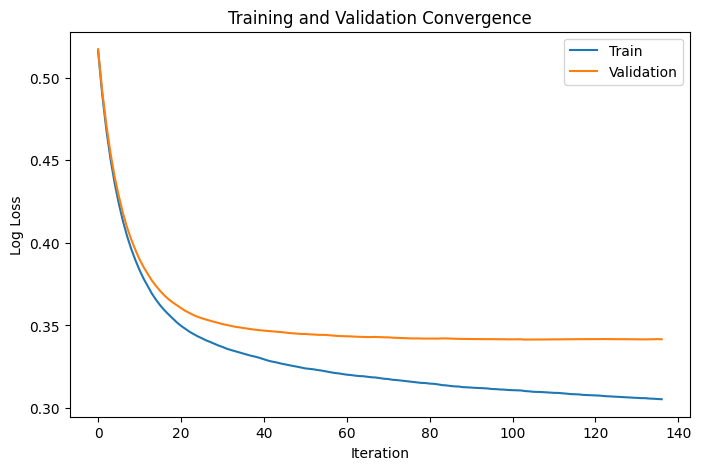

In [6]:
evals_result = model.evals_result()

epochs = len(evals_result["validation_0"]["logloss"])
x_axis = range(0, epochs)

plt.figure(figsize=(8,5))
plt.plot(x_axis, evals_result["validation_0"]["logloss"], label="Train")
plt.plot(x_axis, evals_result["validation_1"]["logloss"], label="Validation")
plt.xlabel("Iteration")
plt.ylabel("Log Loss")
plt.title("Training and Validation Convergence")
plt.legend()

plt.savefig("./figures/adult_convergence.png")
plt.show()

## __Features Importance__

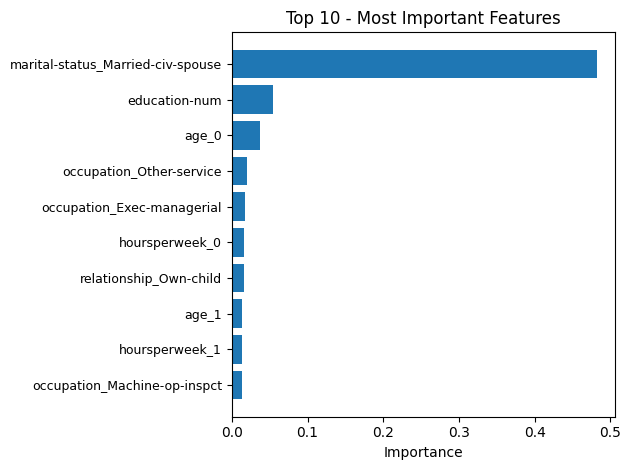

In [7]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)[-10:]
sorted_features = [X.columns[i] for i in sorted_idx]
sorted_importance = feature_importance[sorted_idx]

plt.barh(range(len(sorted_idx)), sorted_importance)
plt.yticks(range(len(sorted_idx)))
plt.yticks(range(len(sorted_idx)), sorted_features, fontsize=9)
plt.title("Top 10 - Most Important Features")
plt.xlabel("Importance")

plt.tight_layout()
plt.savefig("./figures/adult_features_importance.png")
plt.show()

## __Results__

Accuracy - Training: 0.8557
Accuracy - Test: 0.8443


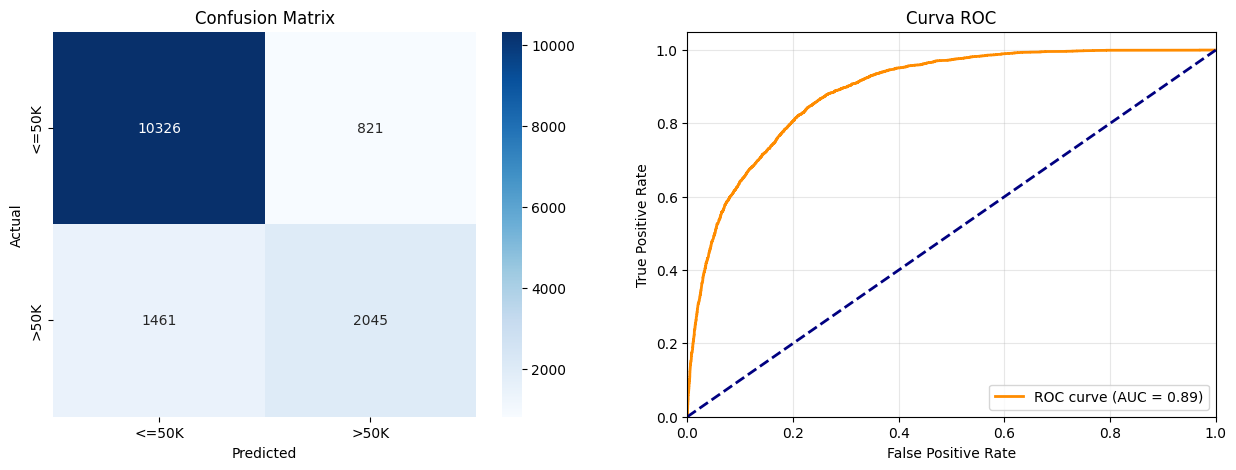

In [8]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_pred_proba_test = model.predict_proba(X_test)[:, 1]

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy - Training: {train_accuracy:.4f}")
print(f"Accuracy - Test: {test_accuracy:.4f}")


fig, axs = plt.subplots(1, 2, figsize=(15, 5))

cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axs[0],
            xticklabels=label_encoder_y.classes_, 
            yticklabels=label_encoder_y.classes_)
axs[0].set_title("Confusion Matrix")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual")

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
roc_auc = auc(fpr, tpr)
axs[1].plot(fpr, tpr, color="darkorange", lw=2, 
               label=f"ROC curve (AUC = {roc_auc:.2f})")
axs[1].plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")
axs[1].set_title("Curva ROC")
axs[1].legend(loc="lower right")
axs[1].grid(True, alpha=0.3)

plt.savefig("./figures/adult_performance.png")
plt.show()